# Challenge based Learning:

## TASK
Count the number of trees in Campus Golm. Estimate the area that is covered by trees on campus. How many trees (in %) are deciduous?

## Members
- Emmanuel Olguin	
- Raphael Kluge 		
- Nikolas Bertrand	

Project repository (Public)
https://github.com/nikolasbertrand/golm_tree_analysis

For this challenge based project we decided to use mainly Python and R programming. 

After fighting with different tools, applications and R we came to the results below. 

While they are not perfect, considering time constraints they give a general picture of the results. Now it all depends on fine tuning. 

To complete the challenge one can follow the general outline:

1. Read the .las file: Start by reading the .las file, which is a common file format used for storing LiDAR data, and load it into memory.
2. Preprocess the data: Once the .las file is loaded, you may need to preprocess the data to remove noise, filter out points that are not relevant to trees, or perform any necessary transformations. This step is important to ensure accurate tree identification.
3. Segment the point cloud: Next, you need to segment the point cloud into individual trees. In general, this can be done by applying clustering algorithms such as DBSCAN (Density-Based Spatial Clustering of Applications with Noise) or region growing algorithms. These algorithms group nearby points together based on their spatial proximity or other attributes.
4. Extract tree features: After segmenting the point cloud into individual trees, you can extract various features from each tree, such as height, crown diameter, or density. These features can be calculated using geometric or statistical methods.
5. Classify the trees: Once the features are extracted, you can classify the trees into different species or categories. This can be done using machine learning algorithms, such as random forests or support vector machines, trained on labeled tree data. 
6. Visualize the results: Finally, you can visualize the identified trees and their attributes to gain insights or generate reports. You can use libraries like matplotlib in Python or lidRVis in R to create visualizations of the identified trees.


In [28]:
# Import libraries
import laspy
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.spatial import cKDTree
from scipy import stats

# Import R libraries 
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
#load_ext rpy2.ipython # first time only
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [18]:
%%R
# LOAD R LIBRARIES
library(lidR)
library(raster)
library(ForestTools)
library(sf)
library(rgdal)


# STEP 1 Filter the input data. 

For the first to tasks we mainly use a lidar file in form of .las as input data.
The las file has 6 return and some classification included. 

In [24]:
#Load Data 
las = laspy.read("/home/nibe/PROJECTS/golm_tree_analysis/data/Golm_May06_2018_Milan_UTM33N_WGS84_6digit_cl.las")
print(f"{np.unique(las.classification)} are the unique classificationsin the point cloud")
print(f"Number of return: {np.unique(las.return_num)}")
# Get information about the point spacing
point_spacing = las.header.scale[0]  # Assuming the scale is the same in all dimensions
# Calculate the resolution
resolution = 1 / point_spacing  # Assuming the point spacing is in meters
# Print the resolution
print(f"Resolution: {resolution} points per meter")

[1 2 5 6 7] are the unique classificationsin the point cloud
Number of return: [1 2 3 4 5 6]
Resolution: 100.0 points per meter


This means we have a resolution of 1, 
Clasifications of 1,2,5,6 and 7 and in total 6 returns

# Some more Preprocessing ... what do different classifications and returns return?
we know that Classification 5 is for vegetation and classification 6 is for buildings. This is According to the ASPRS standard.


So to start of we iterate of the filters and see what we are dealing with. 

In [34]:
#LAS 5-1 
ret = [1, 2, 3]
clas = [5, 6]
filter_las_list = []
for x in clas:
    for y in ret:
        filtered_points = las.points[(las.classification == x) & (las.return_num == y)]
        new_file = laspy.create(point_format=las.header.point_format, file_version=las.header.version)
        new_file.points = filtered_points.copy()
        new_file.write(f"data/filtered_las_{x}_{y}.las")
        print(f"returns class= {x} return {y}, {len(filtered_points)} points")

returns class= 5 return 1, 1763768 points
returns class= 5 return 2, 527410 points
returns class= 5 return 3, 119051 points
returns class= 6 return 1, 2027141 points
returns class= 6 return 2, 19114 points
returns class= 6 return 3, 3795 points


## Let's look at the results.

On the images below we can see that with every return (top row = classification 5 and return 1-4) the amount of cloud points is reduced. 
in 5-1 and partially in 5-2 as well there still remains lots of information from buildings, i.e. walls and the crane. 
one area that is better is the area in front of the mensa at least on 5-1 here it is all clear while on 5-2 there is barely a point. 

in the 2nd row we have the 6-1 las file which shows the buildings from top but the information is unfortunately not limited to the classication == 6 but seeps into other classification 

For the remainder of the work we will limit the work to 5-1,2,3 and will ignore the rest

<img src="img/las51.png" alt="points 5-1" width="400"/>
<img src="img/las52.png" alt="points 5-2" width="400"/>
<img src="img/las53.png" alt="points 5-3" width="400"/>
<img src="img/las54.png" alt="points 5-4" width="400"/>
<img src="img/las61.png" alt="points 6-1" width="400"/>

# NEXT TREE SEGMENTATION
now we switch over to R ...while the pre-processing was done using python, next we switch to R and manly use the forest tool

In [54]:
%%R
las51 <- readLAS("/home/nibe/PROJECTS/golm_tree_analysis/data/filtered_las_5_1.las", select = "xyzr")
las52 <- readLAS("/home/nibe/PROJECTS/golm_tree_analysis/data/filtered_las_5_2.las", select = "xyzr")
las53 <- readLAS("/home/nibe/PROJECTS/golm_tree_analysis/data/filtered_las_5_3.las", select = "xyzr")


## NEXT run the forest tools segment tree function
The segment_trees function in R is used to segment a point cloud into individual trees. It assigns an ID to each point by inserting a new attribute named treeID in the LAS object. This means that every point is associated with a specific tree. This function is part of the lidR package, which is oriented towards point clouds, and provides an immediate way to access a segmented point cloud.


In [60]:
%%R
for (x in c(las51,las52,las53)){
    x <- segment_trees(x, li2012(dt1 = 1.5, dt2 = 2, R = 2, Zu = 15, hmin = 2, speed_up = 2))
}

i2012(dt1 = 1.5, dt2 = 2, R = 2, Zu = 15, hmin = 2, speed_up = 2) is the algorithm used for the segmentation. li2012 is an "all-in-one" point cloud based method for tree segmentation. The parameters dt1, dt2, R, Zu, hmin, and speed_up are specific to the li2012 algorithm. 

Once the trees are segmented, you can perform various analyses at the point-cloud level. For example, you can extract every tree to derive measurements, or delineate the crown shapes of each tree using the crown_metrics() function r-lidar.github.io.

Furthermore, Segment Trees are a type of data structure that stores information about a range of elements in its nodes. It allows users to modify the array and perform range queries in smaller complexity. Applications of Segment Trees include interval scheduling, range-based statistics, and image processing

# NEXT: create Canopy height models 
A Canopy Height Model (CHM) in remote sensing represents the height of the trees. It is the distance between the ground and the top of the trees. CHM is calculated by subtracting the Digital Elevation Model (DEM) from the Digital Surface Model (DSM). The DEM represents the elevation of the earth’s surface, excluding trees, buildings, and other objects. The DSM represents the top of the surface, including the actual heights of trees, buildings, and other objects on the earth’s surface. By subtracting the DEM from the DSM, the residual value or difference between the top of the earth surface and the ground is obtained, which should be the heights of the trees.

Fortunately the ForestTools package have this built in, we just need to choose the algorithm and resolution as well as the subcircle

In [108]:
%%R

kernel <- matrix(1, 3, 3)

# Create a vector of las objects
las_list <- c(las51, las52, las53)

for (i in seq_along(las_list)) {
  las <- las_list[[i]]
  
  # Check if the object is of class LAS
  if (!inherits(las, "LAS")) {
    stop("Invalid input. All objects in the list must be of class LAS.")
  }
  
  chm_var_name <- paste("chm_p2r_las5", i, sep = "")
  
  # Perform operations on each las
  chm <- NULL
  tryCatch({
    chm <- rasterize_canopy(las, 1, p2r(subcircle = 0.2), pkg = "terra")
  }, error = function(err) {
    stop("Error while rasterizing canopy:", conditionMessage(err))
  })
  
  # Assign the result to chm_p2r object
  assign(chm_var_name, chm)
  
  # Print the variable name if it was created
  if (exists(chm_var_name)) {
    print(chm_var_name)
  }
  
  # Perform focal smoothing on the created chm objects
  chm_smoothed <- NULL
  tryCatch({
    chm_smoothed <- terra::focal(get(chm_var_name), w = kernel, fun = median, na.rm = TRUE)
  }, error = function(err) {
    stop("Error during focal smoothing:", conditionMessage(err))
  })

  # Modify variable name for smoothed result
  chm_smoothed_var_name <- paste("chm_p2r_smoothed_las5", i, sep = "")

  # Assign the smoothed result to chm_p2r_smoothed object
  assign(chm_smoothed_var_name, chm_smoothed)
  
  # Print the smoothed variable name if it was created
  if (exists(chm_smoothed_var_name)) {
    print(chm_smoothed_var_name)
  }
  
  # Perform rasterization with pitfree
  chm_pitfree_var_name <- paste("chm_pitfree_las5", i, sep = "")
  chm_pitfree <- NULL
  tryCatch({
    chm_pitfree <- rasterize_canopy(las, 1, pitfree(), pkg = "terra")
  }, error = function(err) {
    print("Error while rasterizing with pitfree. Skipping...")
  })
  
  # Assign the result to chm_pitfree object if it was created
  if (!is.null(chm_pitfree)) {
    assign(chm_pitfree_var_name, chm_pitfree)
    print(chm_pitfree_var_name)
  }
}



[1] "chm_p2r_las51"
[1] "chm_p2r_smoothed_las51"
[1] "chm_pitfree_las51"
[1] "chm_p2r_las52"
[1] "chm_p2r_smoothed_las52"
[1] "Error while rasterizing with pitfree. Skipping..."
[1] "chm_p2r_las53"
[1] "chm_p2r_smoothed_las53"
[1] "Error while rasterizing with pitfree. Skipping..."


Pitfree failed for 5-2 and 5-3 because it needs a first return

# Next we create a function / multiple function for the window size.
This can be done fixed or dynamicaly based on the height of the points. 

The plot shows the relationship between height and weight for each function. The "Dynamic" function has a non-linear relationship with varying slopes and plateaus. The "More Linear" function has a linear relationship with a constant slope. The "Partial Linear and Partial Exponential" function has a combination of linear and exponential relationships with specific ranges.

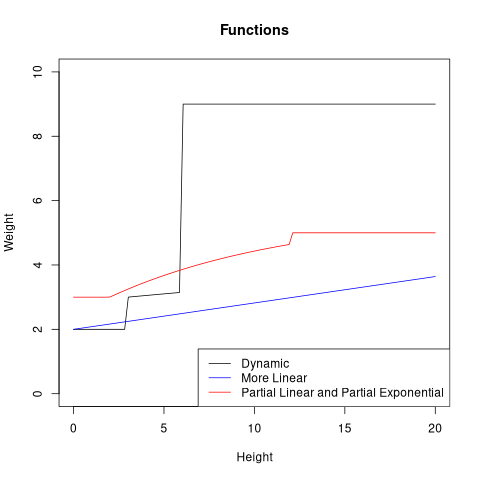

In [69]:
%%R
# Define the functions
f <- function(x) {
  y <- 2.6 * (-(exp(-0.02*(x-3)) - 1)) + 3
  y[x < 3] <- 2
  y[x > 6] <- 9
  return(y)
}

f2 <- function(x) {x * 0.082 + 2}

f3 <- function(x) {
  y <- 2.6 * (-(exp(-0.1*(x-2)) - 1)) + 3
  y[x < 2] <- 3
  y[x > 12] <- 5
  return(y)
}

# Generate x values
x <- seq(0, 20, length.out = 100)

# Generate y values for each function
y1 <- f(x)
y2 <- f2(x)
y3 <- f3(x)

# Plot the functions on a single graphic
plot(x, y1, type = "l", ylim = c(0, 10), xlab = "Height", ylab = "Weight", main = "Functions")
lines(x, y2, col = "blue")
lines(x, y3, col = "red")
legend("bottomright", legend = c("Dynamic", "More Linear", "Partial Linear and Partial Exponential"), col = c("black", "blue", "red"), lty = 1)


The locate_trees function that you're asking about is actually part of the lidR package in R, not the ForestTools package.

locate_trees is used in individual tree detection from remotely sensed data like LiDAR. This function uses various local maxima filtering algorithms to detect the position of individual trees. The function takes in two primary arguments, a canopy height model (CHM)—which is a 2D representation of the forest canopy—and a function, lmf, which specifies the local maximum filter to use:

lmf stands for Local Maxima Filter and determines the rules for finding local maxima points in the dataset. In essence, it helps identify the tree tops of a forest.
So in essence, locate_trees function locates individual trees in a raster canopy height model (raster CHM), and applies a filter as specified by the lmf function.

In [131]:
%%R
# Your datasets and functions
datasets <- c("chm_p2r_las51", "chm_p2r_las52", "chm_p2r_las53", 
              "chm_p2r_smoothed_las51", "chm_p2r_smoothed_las52", 
              "chm_p2r_smoothed_las53", "chm_pitfree_las51")

flist <- list(f=f, f2=f2, f3=f3)

# Initialize variables to store total rows and rows for specific datasets
total_rows <- c()
pf_rows <- c()
p2r_rows <- c()
p2r_s_rows <- c()

# Nested loop with the datasets and functions
for(i in 1:length(datasets)) {
  for(j in 1:length(flist)) {

    # create the variable name
    var_name <- paste0("ttops_", datasets[i], "_", names(flist)[j])

    # tryCatch block to handle the errors
    tryCatch({

      # process the dataset with the function and store result
      result <- locate_trees(get(datasets[i]), lmf(flist[[j]]))

      # Assign the result to a separate variable
      assign(var_name, result)
      
      # Print the number of rows in the result
      row_number <- nrow(result)
      print(paste("Number of rows in", var_name, ":", row_number))

      # Store the number of rows to total_rows
      total_rows <- c(total_rows, row_number)

      # Store the number of rows to specific dataset's variables
      if(grepl("chm_pitfree", datasets[i])){
        pf_rows <- c(pf_rows, row_number)
      } else if(grepl("chm_p2r", datasets[i])){
        p2r_rows <- c(p2r_rows, row_number)
      } else if(grepl("chm_p2r_smoothed", datasets[i])){
        p2r_s_rows <- c(p2r_s_rows, row_number)
      }

    }, error = function(e) {

      # print error message upon error
      print(paste("An error occurred while processing '", 
                  datasets[i], "' with '", names(flist)[j], "'. Details:", e$message))

      # Skip to the next iteration if error occurs
      next
    })

    # print a statement showing which variable the result was stored to
    print(paste("Stored result to:", var_name))
  }
}
# Convert the vectors to numeric if they are not and not missing
p2r_rows <- sapply(p2r_rows, function(x) if(is.numeric(x) & !is.na(x)) as.numeric(x) else NA)
p2r_s_rows <- sapply(p2r_s_rows, function(x) if(is.numeric(x) & !is.na(x)) as.numeric(x) else NA)

# Calculate and print the averages with na.rm = TRUE
p2r_avg <- mean(p2r_rows, na.rm = TRUE)
p2r_s_avg <- mean(p2r_s_rows, na.rm = TRUE)

print(paste("chm_p2r average:", p2r_avg))
print(paste("chm_p2r_smoothed average:", p2r_s_avg))

# Calculate and print the averages
print("Total Average")
print(total_avg <- mean(total_rows, na.rm = TRUE))
pf_avg <- mean(pf_rows, na.rm = TRUE)
p2r_avg <- mean(p2r_rows, na.rm = TRUE)
p2r_s_avg <- mean(p2r_s_rows, na.rm = TRUE)






[1] "Number of rows in ttops_chm_p2r_las51_f : 830"
[1] "Stored result to: ttops_chm_p2r_las51_f"
[1] "Number of rows in ttops_chm_p2r_las51_f2 : 1483"
[1] "Stored result to: ttops_chm_p2r_las51_f2"
[1] "Number of rows in ttops_chm_p2r_las51_f3 : 1637"
[1] "Stored result to: ttops_chm_p2r_las51_f3"
[1] "Number of rows in ttops_chm_p2r_las52_f : 776"
[1] "Stored result to: ttops_chm_p2r_las52_f"
[1] "Number of rows in ttops_chm_p2r_las52_f2 : 1216"
[1] "Stored result to: ttops_chm_p2r_las52_f2"
[1] "Number of rows in ttops_chm_p2r_las52_f3 : 1377"
[1] "Stored result to: ttops_chm_p2r_las52_f3"
[1] "Number of rows in ttops_chm_p2r_las53_f : 555"
[1] "Stored result to: ttops_chm_p2r_las53_f"
[1] "Number of rows in ttops_chm_p2r_las53_f2 : 932"
[1] "Stored result to: ttops_chm_p2r_las53_f2"
[1] "Number of rows in ttops_chm_p2r_las53_f3 : 1130"
[1] "Stored result to: ttops_chm_p2r_las53_f3"
[1] "Number of rows in ttops_chm_p2r_smoothed_las51_f : 807"
[1] "Stored result to: ttops_chm_p2r_smo

In addition: Warning messages:
1: In mean.default(p2r_s_rows, na.rm = TRUE) :
  argument is not numeric or logical: returning NA
2: In mean.default(p2r_s_rows, na.rm = TRUE) :
  argument is not numeric or logical: returning NA


[1] "tree count"
[1] 662
[1] "tree count"
[1] 1252
[1] "tree count"
[1] 1408


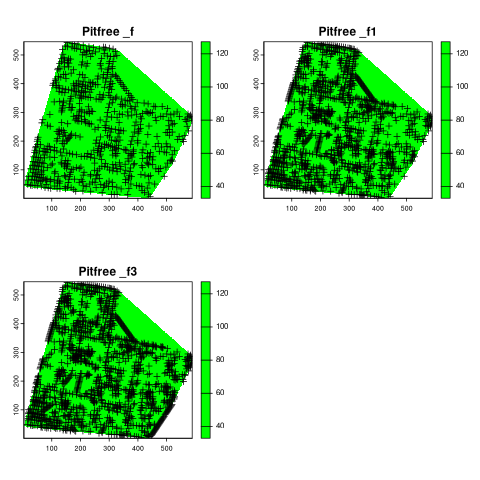

In [124]:
%%R
# Set the layout to have four plots in a 2x2 grid
par(mfrow = c(2, 2))

# Block 1
col <- "green"
plot(chm_pitfree_las51, main = "Pitfree _f", col = col)
plot(sf::st_geometry(ttops_chm_pitfree_las51_f), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_pitfree_las51_f))

# Block 2
col <- "green"
plot(chm_pitfree_las51, main = "Pitfree _f1", col = col)
plot(sf::st_geometry(ttops_chm_pitfree_las51_f2), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_pitfree_las51_f2))

# Block 4
col <- "green"
plot(chm_pitfree_las51, main = "Pitfree _f3", col = col)
plot(sf::st_geometry(ttops_chm_pitfree_las51_f3), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_pitfree_las51_f3))


[1] "tree count"
[1] 830
[1] "tree count"
[1] 1483
[1] "tree count"
[1] 1637


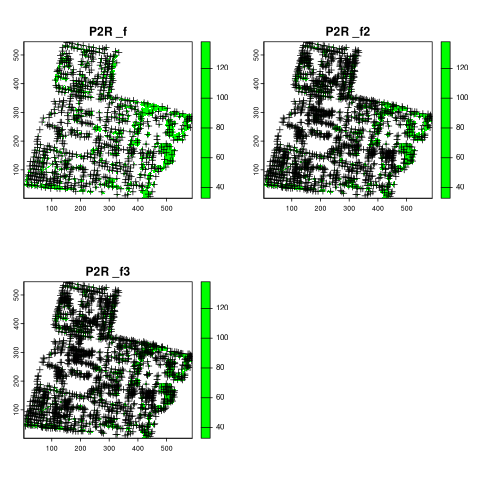

In [126]:
%%R
# Set the layout to have four plots in a 2x2 grid
par(mfrow = c(2, 2))

# Block 1
col <- "green"
plot(chm_p2r_las51, main = "P2R _f", col = col)
plot(sf::st_geometry(ttops_chm_p2r_las51_f), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_las51_f))

# Block 2
col <- "green"

plot(chm_p2r_las51, main = "P2R _f2", col = col)
plot(sf::st_geometry(ttops_chm_p2r_las51_f2), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_las51_f2))

# Block 3
col <- "green"

plot(chm_p2r_las51, main = "P2R _f3", col = col)
plot(sf::st_geometry(ttops_chm_p2r_las51_f3), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_las51_f3))


[1] "tree count"
[1] 776
[1] "tree count"
[1] 1216
[1] "tree count"
[1] 1377


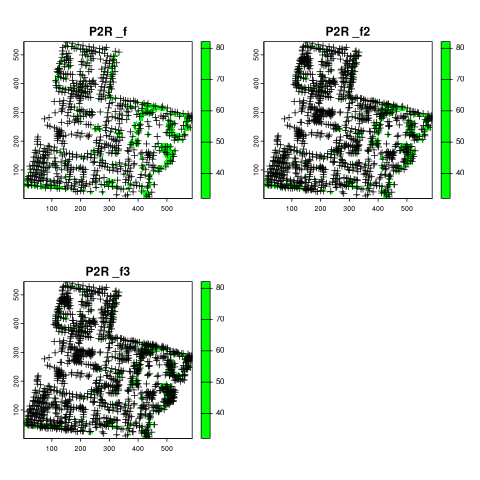

In [127]:
%%R
# Set the layout to have four plots in a 2x2 grid
par(mfrow = c(2, 2))

# Block 1
col <- "green"
plot(chm_p2r_las52, main = "P2R _f", col = col)
plot(sf::st_geometry(ttops_chm_p2r_las52_f), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_las52_f))

# Block 2
col <- "green"

plot(chm_p2r_las52, main = "P2R _f2", col = col)
plot(sf::st_geometry(ttops_chm_p2r_las52_f2), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_las52_f2))

# Block 3
col <- "green"

plot(chm_p2r_las52, main = "P2R _f3", col = col)
plot(sf::st_geometry(ttops_chm_p2r_las52_f3), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_las52_f3))

[1] "tree count"
[1] 776
[1] "tree count"
[1] 932
[1] "tree count"
[1] 1130


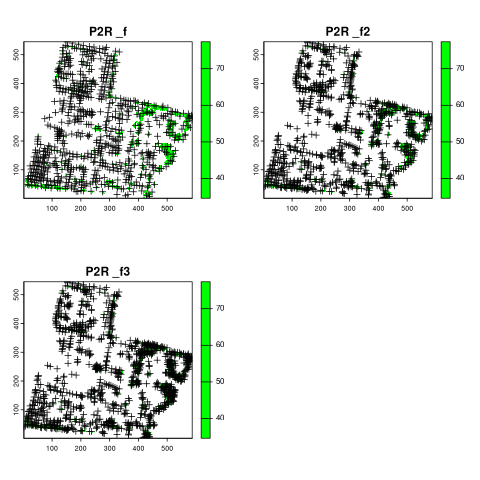

In [128]:
%%R
# Set the layout to have four plots in a 2x2 grid
par(mfrow = c(2, 2))

# Block 1
col <- "green"
plot(chm_p2r_las53, main = "P2R _f", col = col)
plot(sf::st_geometry(ttops_chm_p2r_las52_f), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_las52_f))

# Block 2
col <- "green"

plot(chm_p2r_las53, main = "P2R _f2", col = col)
plot(sf::st_geometry(ttops_chm_p2r_las53_f2), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_las53_f2))

# Block 3
col <- "green"

plot(chm_p2r_las53, main = "P2R _f3", col = col)
plot(sf::st_geometry(ttops_chm_p2r_las53_f3), add = TRUE, pch = 3)
print("tree count")
print(nrow(ttops_chm_p2r_las53_f3))

AT THIS POINT WE WILL REFRAIN FROM PLOTTING the _smoothed plots because of space, and no change in results. 

# NEXT STEP - TREE CROWNS
earlier calculated ttops and foresttools crowns are different aspects of tree analysis in the ForestTools package. The ttops are the treetops detected from a CHM, and the foresttools crowns are the tree crowns outlined from these treetops.

since crown function needs spatRaster we have to reload the las file 

uses the same window size function as above!

for foresttools crown support the vwf algorithm has to be used

[1] 545
                      Value
TreeCount       2806.000000
crownAreaMean     22.237349
crownAreaMedian   12.000000
crownAreaSD       33.179563
crownAreaMin       1.000000
crownAreaMax     554.000000
heightMean        47.155524
heightMedian      44.695000
heightSD           8.337723
heightMin         34.020000
heightMax        137.890000
[1] "Total Crown Area : 62398"


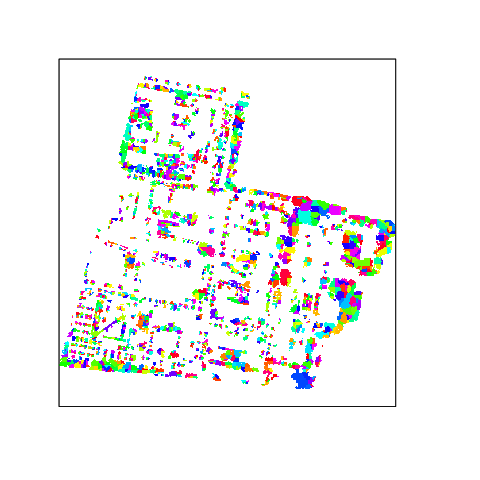

In [162]:
%%R

chm <- rasterize_canopy(las51, 1, p2r(0.6), pkg = "raster")
#f <- function(x) {x * 0.02 + 0.3}

ttops <- vwf(CHM = chm, winFun = f3, minHeight = 2)

plot(chm, xlab = "", ylab = "", xaxt = 'n', yaxt = 'n')
plot(ttops, col = "green", pch = 20, cex = 0.5, add = TRUE)

# Create crown map
crowns <- mcws(treetops = ttops, CHM = chm,  minHeight = 3, verbose = FALSE)

# Plot crowns
plot(crowns, col = sample(rainbow(50), length(unique(crowns[])), replace = TRUE), legend = FALSE, xlab = "", ylab = "", xaxt='n', yaxt = 'n')
print(nrow(crowns))
crowns_poly <- mcws(treetops = ttops, CHM = chm, minHeight = 3, verbose = FALSE, format="polygons")
summary <- sp_summarise(crowns_poly, variables = c("crownArea", "height"))
print(summary)
# Calculate total crown area
total_crown_area <- sum(crowns_poly$crownArea)

# Print total crown area
print(paste("Total Crown Area :", total_crown_area))



[1] 545
                      Value
TreeCount       1409.000000
crownAreaMean     27.945351
crownAreaMedian    9.000000
crownAreaSD       58.215514
crownAreaMin       1.000000
crownAreaMax     746.000000
heightMean        47.099120
heightMedian      44.240000
heightSD           8.378778
heightMin         34.310000
heightMax         82.140000
[1] "Total Crown Area : 39375"


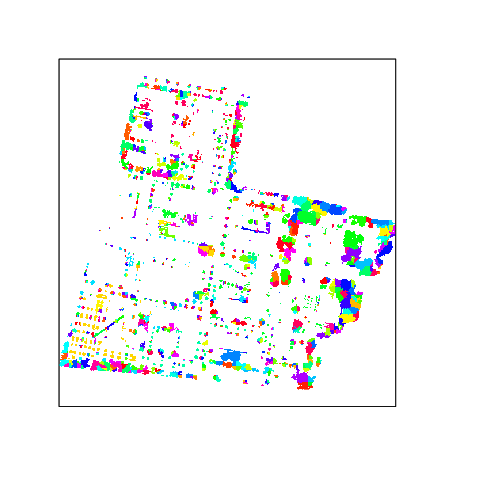

In [167]:
%%R

chm <- rasterize_canopy(las52, 1, p2r(0.6), pkg = "raster")
#f <- function(x) {x * 0.02 + 0.3}

ttops <- vwf(CHM = chm, winFun = f, minHeight = 2)

plot(chm, xlab = "", ylab = "", xaxt = 'n', yaxt = 'n')
plot(ttops, col = "green", pch = 20, cex = 0.5, add = TRUE)

# Create crown map
crowns <- mcws(treetops = ttops, CHM = chm,  minHeight = 3, verbose = FALSE)

# Plot crowns
plot(crowns, col = sample(rainbow(50), length(unique(crowns[])), replace = TRUE), legend = FALSE, xlab = "", ylab = "", xaxt='n', yaxt = 'n')
print(nrow(crowns))
crowns_poly <- mcws(treetops = ttops, CHM = chm, minHeight = 3, verbose = FALSE, format="polygons")
summary <- sp_summarise(crowns_poly, variables = c("crownArea", "height"))
print(summary)
# Calculate total crown area
total_crown_area2 <- sum(crowns_poly$crownArea)

# Print total crown area
print(paste("Total Crown Area :", total_crown_area2))


[1] 544
                     Value
TreeCount       600.000000
crownAreaMean    32.501667
crownAreaMedian   5.000000
crownAreaSD      75.577752
crownAreaMin      1.000000
crownAreaMax    577.000000
heightMean       45.799617
heightMedian     42.485000
heightSD          8.203656
heightMin        34.600000
heightMax        77.370000


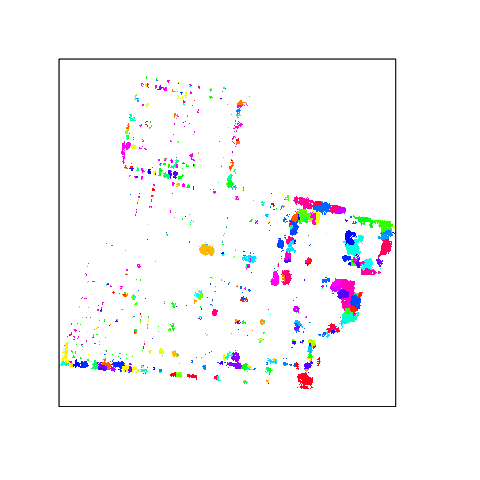

In [179]:
%%R 
chm <- rasterize_canopy(las53, 1, p2r(0.2), pkg = "raster")
#f <- function(x) {x * 0.02 + 0.3}

ttops <- vwf(CHM = chm, winFun = f, minHeight = 2)

plot(chm, xlab = "", ylab = "", xaxt = 'n', yaxt = 'n')
plot(ttops, col = "green", pch = 20, cex = 0.5, add = TRUE)

# Create crown map
crowns <- mcws(treetops = ttops, CHM = chm,  minHeight = 3, verbose = FALSE)

# Plot crowns
plot(crowns, col = sample(rainbow(50), length(unique(crowns[])), replace = TRUE), legend = FALSE, xlab = "", ylab = "", xaxt='n', yaxt = 'n')
print(nrow(crowns))
crowns_poly <- mcws(treetops = ttops, CHM = chm, minHeight = 3, verbose = FALSE, format="polygons")
summary <- sp_summarise(crowns_poly, variables = c("crownArea", "height"))
print(summary)
# Calculate total crown area
total_crown_area3 <- sum(crowns_poly$crownArea)




In [180]:
%%R
total_total_crown_area <- total_crown_area2 + total_crown_area3
ttca <- total_total_crown_area/2
print(ttca)

[1] 29438


In [181]:
%%R 
# Read the LAS file
las2 <- readLAS("/home/nibe/PROJECTS/golm_tree_analysis/data/Golm_May06_2018_Milan_UTM33N_WGS84_6digit_cl.las")
# Specify the resolution of the raster data
resolution <- 1
# Create a grid using the grid_metrics function
# Here we use the length function as our metric, which will return 1 for all grid cells that contain at least one point.
metrics <- grid_metrics(las2, ~length(X), resolution)

# Calculate the total area covered by the .las file
# Total area is computed by summing up non-NA grid cells and multiplying by the cell's area
total_area <- sum(!is.na(values(metrics))) * resolution * resolution
print(paste0("Total Area :", total_area))

crown_values <- getValues(crowns)
unique_crowns <- unique(crown_values)

# compare total Crown Area with total area
print(paste0("Proportion of area covered by tree crowns : ", (ttca/total_area)*100, "__%"))

[1] "Total Area :192458"
[1] "Proportion of area covered by tree crowns : 15.2958047989691__%"


# NEXT DECIDIOUS TREES ETC>